# Data Strikes (and Boycotts): Simulated Campaign Results

## What's in this notebook?
This notebook includes code for exploring the results of simulated boycotts. It also generates plots (for papers/presentations). This notebook covers 3 broad categories of experiments

1. Book Crossing random boycotts
2. Book Crossing homogeneous boycotts (e.g. fans of Comedy movies boycott together, people of a single age group boycott together)
3. MovieLens 1M random boycotts

It uses code from p_b_curve.py for plotting
It preloads constants from viz_constants (# users, # ratings, # hits). Can see how those are computed in ratings_hists notebook.


In [1]:
import viz_constants 
import importlib

# reload constants from file
# see https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
importlib.reload(viz_constants)
(
    num_users,num_items, num_ratings, num_hits
) = (
    viz_constants.num_users,viz_constants.num_items, viz_constants.num_ratings, viz_constants.num_hits
)
num_users,num_items, num_ratings, num_hits

({'ml-1m': 6040, 'bcrossing': 12293},
 {'ml-1m': 3706, 'bcrossing': 13768},
 {'ml-1m': 1000209, 'bcrossing': 145888},
 {'ml-1m': 575281, 'bcrossing': 90421})

In [2]:
from collections import defaultdict, OrderedDict
import json
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_color_codes("dark")

import scipy
from scipy import stats
from scipy.interpolate import interp1d

# http://files.grouplens.org/datasets/movielens/ml-20m-README.txt
for dataset in ['ml-1m','bcrossing']:
    ratio = num_ratings[dataset] / num_users[dataset]
    sparsity =1 -num_ratings[dataset]/(num_users[dataset]*num_items[dataset])
    print(dataset, 'ratio of ratings to users:', ratio)
    print(dataset, 'sparsity of dataset :', sparsity)


ml-1m ratio of ratings to users: 165.5975165562914
ml-1m sparsity of dataset : 0.9553163743776871
bcrossing ratio of ratings to users: 11.867566907996421
bcrossing sparsity of dataset : 0.999138032618536


In [3]:
print('Pandas:', pd.__version__, 'Seaborn:', sns.__version__, 'numpy:', np.__version__, 'scipy:', scipy.__version__)

Pandas: 1.4.4 Seaborn: 0.11.2 numpy: 1.23.4 scipy: 1.8.1


First things first: let's load our master data files. Each is a single csv that was created by the `process_all.py` script.

In [4]:
df_bc = pd.read_csv('all_results.csv', dtype={'indices': str})
df_bc['dataset'] = 'bcrossing'
#assert len(df_bc) == len(df_bc[df_bc.ratingfrac.notna()])

In [5]:

pd.set_option('display.max_columns', None)
df_bc[100:105]


,Unnamed: 0.1,name,algo_name,indices,ratingfrac,userfrac,Unnamed: 0,avgest_all,avgest_all-like-boycott,avgest_boycott,avgest_frac_all,avgest_frac_all-like-boycott,avgest_frac_boycott,avgest_frac_like-boycott,avgest_frac_non-boycott,avgest_like-boycott,avgest_non-boycott,avgrating_all,avgrating_all-like-boycott,avgrating_boycott,avgrating_frac_all,avgrating_frac_all-like-boycott,avgrating_frac_boycott,avgrating_frac_like-boycott,avgrating_frac_non-boycott,avgrating_like-boycott,avgrating_non-boycott,falsepos_all,falsepos_all-like-boycott,falsepos_boycott,falsepos_frac_all,falsepos_frac_all-like-boycott,falsepos_frac_boycott,falsepos_frac_like-boycott,falsepos_frac_non-boycott,falsepos_like-boycott,falsepos_non-boycott,fit_time_all,fit_time_all-like-boycott,fit_time_boycott,fit_time_like-boycott,fit_time_non-boycott,hits_all,hits_all-like-boycott,hits_boycott,hits_frac_all,hits_frac_all-like-boycott,hits_frac_boycott,hits_frac_like-boycott,hits_frac_non-boycott,hits_like-boycott,hits_non-boycott,increase_avgest_all,increase_avgest_all-like-boycott,increase_avgest_boycott,increase_avgest_frac_all,increase_avgest_frac_all-like-boycott,increase_avgest_frac_boycott,increase_avgest_frac_like-boycott,increase_avgest_frac_non-boycott,increase_avgest_like-boycott,increase_avgest_non-boycott,increase_avgrating_all,increase_avgrating_all-like-boycott,increase_avgrating_boycott,increase_avgrating_frac_all,increase_avgrating_frac_all-like-boycott,increase_avgrating_frac_boycott,increase_avgrating_frac_like-boycott,increase_avgrating_frac_non-boycott,increase_avgrating_like-boycott,increase_avgrating_non-boycott,increase_falsepos_all,increase_falsepos_all-like-boycott,increase_falsepos_boycott,increase_falsepos_frac_all,increase_falsepos_frac_all-like-boycott,increase_falsepos_frac_boycott,increase_falsepos_frac_like-boycott,increase_falsepos_frac_non-boycott,increase_falsepos_like-boycott,increase_falsepos_non-boycott,increase_hits_all,increase_hits_all-like-boycott,increase_hits_boycott,increase_hits_frac_all,increase_hits_frac_all-like-boycott,increase_hits_frac_boycott,increase_hits_frac_like-boycott,increase_hits_frac_non-boycott,increase_hits_like-boycott,increase_hits_non-boycott,increase_mae_all,increase_mae_all-like-boycott,increase_mae_boycott,increase_mae_like-boycott,increase_mae_non-boycott,increase_ndcg10_all,increase_ndcg10_all-like-boycott,increase_ndcg10_boycott,increase_ndcg10_frac_all,increase_ndcg10_frac_all-like-boycott,increase_ndcg10_frac_boycott,increase_ndcg10_frac_like-boycott,increase_ndcg10_frac_non-boycott,increase_ndcg10_like-boycott,increase_ndcg10_non-boycott,increase_ndcg5_all,increase_ndcg5_all-like-boycott,increase_ndcg5_boycott,increase_ndcg5_frac_all,increase_ndcg5_frac_all-like-boycott,increase_ndcg5_frac_boycott,increase_ndcg5_frac_like-boycott,increase_ndcg5_frac_non-boycott,increase_ndcg5_like-boycott,increase_ndcg5_non-boycott,increase_ndcgfull_all,increase_ndcgfull_all-like-boycott,increase_ndcgfull_boycott,increase_ndcgfull_frac_all,increase_ndcgfull_frac_all-like-boycott,increase_ndcgfull_frac_boycott,increase_ndcgfull_frac_like-boycott,increase_ndcgfull_frac_non-boycott,increase_ndcgfull_like-boycott,increase_ndcgfull_non-boycott,increase_normhits_all,increase_normhits_all-like-boycott,increase_normhits_boycott,increase_normhits_frac_all,increase_normhits_frac_all-like-boycott,increase_normhits_frac_boycott,increase_normhits_frac_like-boycott,increase_normhits_frac_non-boycott,increase_normhits_like-boycott,increase_normhits_non-boycott,increase_prec10t4_all,increase_prec10t4_all-like-boycott,increase_prec10t4_boycott,increase_prec10t4_frac_all,increase_prec10t4_frac_all-like-boycott,increase_prec10t4_frac_boycott,increase_prec10t4_frac_like-boycott,increase_prec10t4_frac_non-boycott,increase_prec10t4_like-boycott,increase_prec10t4_non-boycott,increase_prec5t4_all,increase_prec5t4_all-like-boycott,increase_prec5t4_boycott,increase_prec5t4_frac_all,increase_prec5t4_frac_all-like-boycott,increase_p

In [6]:
df_bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Columns: 1122 entries, Unnamed: 0.1 to dataset
dtypes: float64(1112), int64(4), object(6)
memory usage: 19.3+ MB


Now we apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.
2. Calculate the number of ratings missing per experiment (so we can estimate how much we'd "expect" performance to decrease)
3. Calculate the number of ratings missing per experiment, rounded to the nearest 10^4

4. Computed surfaced hits

Average # of surfaced hits for some group is equal to the totalhits for that group divided by the total # of possible hits averaged across folds

Because we use 5-fold validation, the total # of possible hits averaged across folds is total # of possible hits in the dataset divided by 5.

In [7]:
for df, dataset in [
   # (df_1m, 'ml-1m',),
   # (df_20m, 'ml-20m',),
    (df_bc, 'bcrossing',),
]:
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'GlobalMean')
    with open(filename_ratingcv_standards, 'r') as f:
        global_mean_res = json.load(f)
        
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'SVD')
    with open(filename_ratingcv_standards, 'r') as f:
        svd_res = json.load(f)
    
    df['num_users_boycotting'] = [(num_users[dataset] - int(x)) / num_users[dataset] for x in df.num_users]
    df['num_ratings_missing'] = [num_ratings[dataset] - int(x) for x in df.num_ratings]
    df['nrm_rounded'] = [round(x, -3) for x in df.num_ratings_missing]
    
    new_metric = 'surfaced-hits'

    groups = ['all', 'non-boycott', 'like-boycott', 'boycott']
    if dataset == 'ml-20m':
        groups = ['all', 'non-boycott', 'boycott'] # there are no like-boycotters in 20m
    for group in groups:
        # need to compute the total number of possible hits in our tests
        # can take the average number of hits for SVD
        #denom = (svd_res['hits'] / svd_res['normhits'] * num_users[dataset])
        denom = num_hits[dataset] / 5
        
        
        # Want to see the # hits per run, # users, and # ideal hits?
        print(svd_res['totalhits'], num_users[dataset], denom)

        # just divide totalhits by # ideal hits (total # hits / # folds) 
        for a in [
            '',
            'increase_',
            'standards_',
        ]:
            key = a + new_metric + '_' + group
            print(key)
            df[key] = [x / denom for x in df[a + 'totalhits_' + group]]

    # handle 'not-like-boycott' group
    other = 'totalhits'

    if dataset == 'bcrossing': # there is no not_like-boycott in 20m
        for x in [
            other,
            'standards_' + other,
            'increase_' + other,
            new_metric,
            'standards_' + new_metric,
            'increase_' + new_metric,
        ]:
            # the total hits of not-like-boycotters and like-boycotters add up to total hits of all non boycotters
            # the same is true for surfaced hits (surfaced hits is linearly proportional to total hits)
            df[x + '_not-like-boycott'] = df[x + '_non-boycott'] - df[x + '_like-boycott']

        df['percent_increase_' + other + '_not-like-boycott'] = 100 * (
            df['increase_' + other + '_not-like-boycott']
        ) / df['standards_' + other + '_not-like-boycott']

    for group in groups:
        df['percent_increase_' + new_metric + '_' + group] = 100 * (
            df['increase_' + new_metric + '_' + group]
        ) / df['standards_' + new_metric + '_' + group]

14819.8 12293 18084.2
surfaced-hits_all
increase_surfaced-hits_all
standards_surfaced-hits_all
14819.8 12293 18084.2
surfaced-hits_non-boycott
increase_surfaced-hits_non-boycott
standards_surfaced-hits_non-boycott
14819.8 12293 18084.2
surfaced-hits_like-boycott
increase_surfaced-hits_like-boycott
standards_surfaced-hits_like-boycott
14819.8 12293 18084.2
surfaced-hits_boycott
increase_surfaced-hits_boycott
standards_surfaced-hits_boycott


# EDIT ME
Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [8]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
#id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    'ndcg5',
    'tailndcg10',
    'ndcgfull',
    'prec10t4',
    'rec10t4',
    'prec5t4',
    'rec5t4',
    'tailprec10t4',
    'tailrec10t4',
    #'prec5t9',
    #'tailprec5t9',
    'hits',
    'totalhits',
    'normhits',
]

organized_experiments = [
     'state',  'age'
]

# the algorithms we investigate (see old results for KNN experiments)
algo_names = [
    #'KNNBaseline_item_msd',
    'SVD'
]
# the standards we compare against
standard_algo_names = [
    'SVD8',
    'SVD10',
    'SVD',
    'SVD20',
    'SVD30',
   'SVD40',
   'SVD50',
    'SVD70',
    'SVD90',
    'SVD100',
    'SVD110',
    'GlobalMean',
    
    #'GuessThree',
    'MovieMean', 
    'KNNBaseline_item_msd',
    'KNNBasic_user_msd',
    'KNNBasic_item_msd',
]
    
    

## Load and Organize Standard Results
For any of our visualizations to be meaningful, we need standard results to compare the boycott results to. These standards let us evaluate "what is the effect of the boycott compared to other algorithms".

In particular, we compare the boycott performance to performance when using very non-personalized algorithms (MovieMean) and simpler personalized algorithms (user-based KNN, item-based KNN).

Below, we load these results from json files into Python data structures so we can use below when generating plots.

In [9]:
dataset_to_algo_to_metric_to_altalgo = {}
ds2standards = {}

one_mill_svd = {}
for dataset in [
    'bcrossing',
]:
    standard_results = {}
    algo2metric2altalgo = defaultdict(lambda: defaultdict(dict))

    for algo_name in standard_algo_names:
        try:
            filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
                dataset, algo_name)
            with open(filename_ratingcv_standards, 'r') as f:
                standard_results[algo_name] = json.load(f)
                if algo_name == 'SVD' and dataset == 'bcrossing':
                    one_mill_svd = standard_results[algo_name]
        except FileNotFoundError:
            print('File not found: {}'.format(filename_ratingcv_standards))
    for main_algo_name in algo_names:
        for metric in metrics:
            goodval = standard_results[main_algo_name].get(metric, 0)
            for st_algo_name in standard_algo_names:
                val = standard_results.get(st_algo_name, {}).get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = 0
                if metric == 'normhits':

                    denom = num_hits[dataset] / 5
                    #denom = (standard_results['SVD']['hits'] / standard_results['SVD']['normhits'] * num_users[dataset])
                    print(st_algo_name)
                    # since user isn't computed for 20m
                    
                    if st_algo_name in standard_results:
                        goodval = standard_results[st_algo_name].get('totalhits', 0) / denom
                        standard_results[st_algo_name]['surfaced-hits'] = goodval
                        
                        algo2metric2altalgo[main_algo_name]['surfaced-hits'][st_algo_name] = algo2metric2altalgo[
                            main_algo_name]['totalhits'][
                            st_algo_name
                        ]
                        #algo2metric2altalgo[main_algo_name]['surfaced-hits'][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
           
    dataset_to_algo_to_metric_to_altalgo[dataset] = algo2metric2altalgo
    ds2standards[dataset] = standard_results
# uncomment to examine
# pprint(dataset_to_algo_to_metric_to_altalgo)
# pprint(ds2standards)

SVD8
SVD10
SVD
SVD20
SVD30
SVD40
SVD50
SVD70
SVD90
SVD100
SVD110
GlobalMean
MovieMean
KNNBaseline_item_msd
KNNBasic_user_msd
KNNBasic_item_msd


In [10]:
ds2standards['bcrossing']['SVD']

{'rmse': 0.7845635083730167,
 'mae': 0.6036153715234898,
 'prec10t4': 0.8288048621036077,
 'tailprec10t4': 0.8419457244065722,
 'prec10t4_frac': 0.751562909589317,
 'tailprec10t4_frac': 0.712802851411261,
 'prec5t4': 0.8312211203192883,
 'tailprec5t4': 0.8434405104088789,
 'prec5t4_frac': 0.751562909589317,
 'tailprec5t4_frac': 0.712802851411261,
 'rec10t4': 0.9776498702863898,
 'tailrec10t4': 0.9843545126835744,
 'rec10t4_frac': 0.751562909589317,
 'tailrec10t4_frac': 0.712802851411261,
 'rec5t4': 0.9277268067507244,
 'tailrec5t4': 0.9452992449000392,
 'rec5t4_frac': 0.751562909589317,
 'tailrec5t4_frac': 0.712802851411261,
 'ndcg10': 0.828520104038448,
 'tailndcg10': 0.8258924915992782,
 'ndcg10_frac': 0.06104623790563548,
 'tailndcg10_frac': 0.042684598479342785,
 'ndcg5': 0.8279471905011059,
 'tailndcg5': 0.829113040206581,
 'ndcg5_frac': 0.17610861204473388,
 'tailndcg5_frac': 0.13613914404109054,
 'ndcgfull': 0.9601195287967197,
 'tailndcgfull': 0.9651314702887331,
 'ndcgfull_fra

In [11]:
a = ds2standards['bcrossing']['SVD']['surfaced-hits'] - ds2standards['bcrossing']['MovieMean']['surfaced-hits']

print('bcrossing:', a)

bcrossing: 0.00021012817818866214


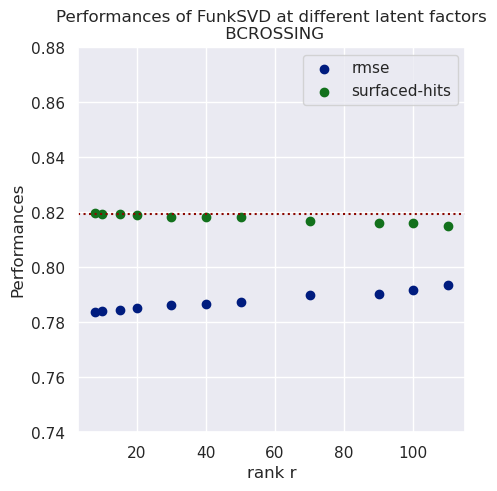

In [76]:
import matplotlib.pyplot as plt


c1={'r':[8,10,15,20,30,40,50,70,90,100,110],
    'rmse':[ds2standards['bcrossing']['SVD8']['rmse'],ds2standards['bcrossing']['SVD10']['rmse'],
            ds2standards['bcrossing']['SVD']['rmse'],ds2standards['bcrossing']['SVD20']['rmse'],
            ds2standards['bcrossing']['SVD30']['rmse'],ds2standards['bcrossing']['SVD40']['rmse'],
            ds2standards['bcrossing']['SVD50']['rmse'],ds2standards['bcrossing']['SVD70']['rmse'],
            ds2standards['bcrossing']['SVD90']['rmse'],ds2standards['bcrossing']['SVD100']['rmse'],
            ds2standards['bcrossing']['SVD110']['rmse']],
   'surfaced-hits':[ds2standards['bcrossing']['SVD8']['surfaced-hits'],ds2standards['bcrossing']['SVD10']['surfaced-hits'],
                    ds2standards['bcrossing']['SVD']['surfaced-hits'],ds2standards['bcrossing']['SVD20']['surfaced-hits'],
                    ds2standards['bcrossing']['SVD30']['surfaced-hits'],ds2standards['bcrossing']['SVD40']['surfaced-hits'],
                    ds2standards['bcrossing']['SVD50']['surfaced-hits'],ds2standards['bcrossing']['SVD70']['surfaced-hits'],
                    ds2standards['bcrossing']['SVD90']['surfaced-hits'],ds2standards['bcrossing']['SVD100']['surfaced-hits'],
                    ds2standards['bcrossing']['SVD110']['surfaced-hits']],
     }
dic=pd.DataFrame(c1)
plt.figure(figsize=(5,5))
plt.scatter(dic['r'],dic['rmse'],color='b',label='rmse')
plt.scatter(dic['r'],dic['surfaced-hits'],color='g',label='surfaced-hits')

plt.axhline(y=ds2standards['bcrossing']['MovieMean']['surfaced-hits'],color='r',linestyle=':')
plt.xlabel("rank r")
plt.ylabel("Performances")
plt.title("Performances of FunkSVD at different latent factors\n BCROSSING")
plt.yticks(np.arange(0.74, 0.88, step=0.02))
plt.legend()


## Reported Results: The personalization gap in units of surfaced hits for bcrossing


## Reported results: SVD standard surfaced-hits for bcrossing


In [13]:
round(ds2standards['bcrossing']['SVD']['surfaced-hits'] * 100, 1)

81.9

In [14]:
normalize_hits = False

for df, dataset in [
    (df_bc, 'bcrossing',),
    #(df_1m, 'ml-1m',),
    #(df_20m, 'ml-20m',),
]:
    metric2altalgo = dataset_to_algo_to_metric_to_altalgo[dataset]['SVD']
    # will only work for SVD as its written right now.
    
    #personalization_boost_coefficient
    for pbc in [
        1.1, 1.02, 2, 4, 8,
    ]:
        for old_metric, k in [
            ('prec10t4', 10),
            #('ndcg10', 10),
            # the actual count of 4 star ratings in the whole ds
            ('hits', 1),
            ('totalhits', 1),
            ('normhits', 1)
        ]:
            for group in ['non-boycott', 'all']:
                # name the new dataframe column
                new_metric = '{}boosthits-{}'.format(pbc, old_metric)
                total_possible_hits = num_users[dataset] * k
                if old_metric == 'totalhits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric]
                elif old_metric == 'hits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric] * num_users[dataset]
                
                # boycotting users provide 0 hits. 
                # so with a full boycott, damage = total possible hits
                comparison = -1 * total_possible_hits
                #comparison = -1 * ds2standards[dataset]['SVD'][old_metric] * total_possible_hits

                key_template = 'percent_increase_{}_{}'
                new_key = key_template.format(new_metric, group)

   
                # no missing users in a strike ("All Users" perspective)
                if group == 'all':
                    frac_miss_arr = [0] * len(df.index)
                # there are missing users in a data boycott!
                else:
                    frac_miss_arr = list(df['num_users_boycotting'])

                labor_metric = 'labor-' + new_metric
                consumer_metric = 'consumer-' + new_metric

                # get the predicted diff if we switched to MovieMean
                pred_diff = metric2altalgo[old_metric]['MovieMean']
                # should get more negative as prec_val gets more negative
                #print(pred_diff)
                coefficients = np.polyfit(
                    [pred_diff, 0], # x values
                    [total_possible_hits/pbc - total_possible_hits, 0],# y values
                    1, # polynomial order, i.e. this is a line
                )

                df[key_template.format(labor_metric, group)] = [
                    ( coefficients[1] + coefficients[0] * prec_val  * (1 - frac_miss)) for (
                        prec_val, frac_miss
                    ) in zip(df[key_template.format(old_metric, group)], frac_miss_arr)
                ]
                df[key_template.format(consumer_metric, group)] = [
                    (comparison * frac_miss) for frac_miss in frac_miss_arr
                ]

                df[new_key] = [
                    (labor_power + consumer_power) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]
                df[new_key.replace('percent_increase_', '')] = [
                    (labor_power + consumer_power + ds2standards[dataset]['SVD']['totalhits']) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]

                if normalize_hits:
                    print('Normalizing. Will divide hit values by total possible hits.')
                    df[new_key] /= total_possible_hits
                    df[key_template.format(labor_metric, group)] /= total_possible_hits
                    df[key_template.format(consumer_metric, group)] /= total_possible_hits

                for st_al_nm in standard_algo_names:
                    old_val = metric2altalgo[old_metric][st_al_nm]
                    # convert from percent to raw precision change
                    old_val *= ds2standards[dataset]['SVD'][old_metric] / 100
                    # multiply by k and the probability of clicks b/c we want to get from prec@5 to hits
                    if not normalize_hits:
                        old_val *= total_possible_hits
                    metric2altalgo[new_metric][st_al_nm] = old_val
                    metric2altalgo[labor_metric][st_al_nm] = old_val
                    metric2altalgo[consumer_metric][st_al_nm] = old_val
            try:
                df['increase_hit-ratio@{}_non-boycott'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            except ZeroDivisionError:
                df['increase_hit-ratio@{}_non-boycott'.format(k)] = [
                    float("nan") for (boycott_val, strike_val) in zip(
                        df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            
            
            try:
                df['increase_hit-ratio@{}_all'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            except ZeroDivisionError:
                df['increase_hit-ratio@{}_all'.format(k)] = [
                    float("nan") for (boycott_val, strike_val) in zip(
                        df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]   
                
                
            #print(df[['num_users_boycotting', 'increase_hits-prec5t4_non-boycott', 'increase_hits-prec5t4_all', 'increase_hit-ratio@5_non-boycott']])


/tmp/ipykernel_5618/2882147894.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_key] = [
/tmp/ipykernel_5618/2882147894.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_key.replace('percent_increase_', '')] = [
/tmp/ipykernel_5618/2882147894.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = 

## Seperate out our data
We want to separate the simuated boycotts into homogenous vs. heterogenous boycotts. We can also check that we have the # of samples and experiment indices that we expect.

# Reported Results: Number of Samples per strike/boycott group

In [15]:


samples_df_bc = df_bc[df_bc['type'] == 'sample_users']
print('\n===Heterogenous Boycotts===\n')
print(samples_df_bc.name.value_counts())
print(samples_df_bc['indices'].value_counts())

org_df = df_bc[df_bc['type'].isin(organized_experiments)]
print('\n===Homogenous Boycotts===\n')
print(org_df.name.value_counts())
print(org_df['indices'].value_counts())



===Heterogenous Boycotts===

1 user sample        50
6 user sample        50
12280 user sample    50
11063 user sample    50
9834 user sample     50
8605 user sample     50
7375 user sample     50
6146 user sample     50
4917 user sample     50
3687 user sample     50
2458 user sample     50
12170 user sample    50
1229 user sample     50
614 user sample      50
122 user sample      50
61 user sample       50
12 user sample       50
12290 user sample    50
Name: name, dtype: int64
1-to-50    900
Name: indices, dtype: int64

===Homogenous Boycotts===

Under 18 excluded          50
portugal excluded          50
ireland excluded           50
philippine excluded        50
romania excluded           50
finland excluded           50
singapore excluded         50
new zealand excluded       50
austria excluded           50
italy excluded             50
malaysia excluded          50
switzerland excluded       50
netherlands excluded       50
france excluded            50
18-24 excluded        

### Bonus analysis: Compare Precision-Estimated Hits to Actual Hits

Here we look at what happens if we use precision to estimate # hits (based on  linear `precision ~ hits` model)


   num_users_boycotting    variable     value
0              0.000081  ndcg10_all  0.828291
1              0.000081  ndcg10_all  0.828796
2              0.000081  ndcg10_all  0.825417
3              0.000081  ndcg10_all  0.826641
4              0.000081  ndcg10_all  0.827819


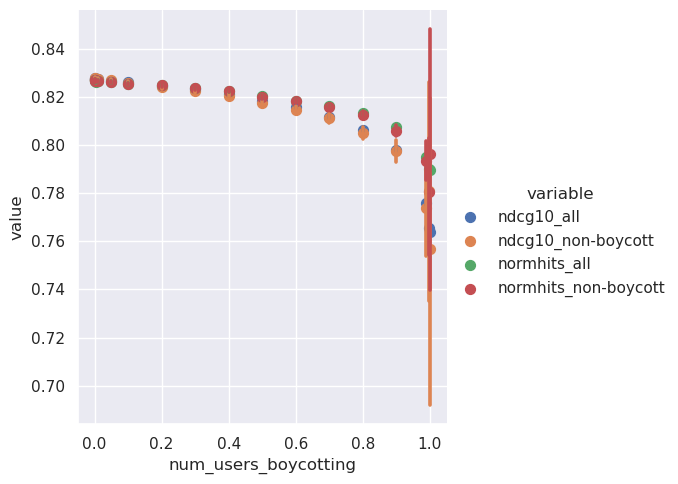

In [16]:
hits_df = samples_df_bc.copy()
hits_df = hits_df[~hits_df.hits_all.isna()]
hits_metric = 'ndcg10'
metric2 = 'normhits'
include = [
    'num_users_boycotting', 
]
hits_cols = [
    '{}_all'.format(hits_metric), 
    '{}_non-boycott'.format(hits_metric),
    #'{}_boycott'.format(hits_metric),
]
# for col in hits_cols:
#     hits_df[col] *= 0.76 / 14.75#num_users['ml-1m']

plot_metric2 = True
include += hits_cols
if plot_metric2:
    cols = [
        '{}_all'.format(metric2), 
        '{}_non-boycott'.format(metric2),
    ]

    include += cols
    
hits_df = hits_df[include].melt(id_vars='num_users_boycotting')
print(hits_df.head())

# for k in hits_df.num_users_boycotting:
#     print(k)
#     matches_from_hits = hits_df[hits_df.num_users_boycotting == k]
#     matches_from_orig = samples_df_1m[hits_df.num_users_boycotting == k]

sns.lmplot(
        x="num_users_boycotting", y="value", hue='variable', data=hits_df,
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
    )
plt.show()

In [17]:
from collections import defaultdict
name2vals = defaultdict(list)

for name, group in hits_df.groupby('num_users_boycotting'):
    #print(name)
    for subname, subgroup in group.groupby('variable'):
        #print(subname, subgroup['value'].mean())
        name2vals[subname].append(subgroup['value'].mean())
        
print(name2vals)

defaultdict(<class 'list'>, {'ndcg10_all': [0.8277408207455161, 0.8276865768302889, 0.8279725584914598, 0.827717533576124, 0.8276654230294278, 0.8269213514075439, 0.8263597080887121, 0.8248846591583983, 0.8233746476420276, 0.8212457434384989, 0.8184963542302175, 0.8160722796124946, 0.811966733698696, 0.8064631277063711, 0.7982425246176597, 0.7758659259710139, 0.7657658091583105, 0.764054364725166], 'ndcg10_non-boycott': [0.82774073337833, 0.8276706352959741, 0.827960139760077, 0.8277654863285129, 0.8277285781728785, 0.8270043350071952, 0.8261245308965353, 0.8241494850745075, 0.8226777615254222, 0.8205892877030314, 0.8174351260572166, 0.8147113449155643, 0.8112041219815803, 0.8052827212759712, 0.7976391567046716, 0.7737388178267074, 0.7809260137019365, 0.7567105012533897], 'normhits_all': [0.8267956444743528, 0.8270461622306142, 0.8269997123191541, 0.8265389071976645, 0.8267198331689926, 0.826500098545963, 0.8256837531907992, 0.8251715558045034, 0.823917207740583, 0.8225917811265385, 0.

### Do two metrics correlate?

In [18]:
from scipy.stats import pearsonr, spearmanr

try:
    for group in [
        'all', 'non-boycott',
    ]:
        x = '{}_{}'.format(hits_metric,group)
        y = '{}_{}'.format(metric2, group)
        print(x, y)
        print(pearsonr(name2vals[x], name2vals[y]))
#         plt.plot(name2vals[x], name2vals[y])
#         plt.show()
except Exception as err:
    print(err)
    pass

ndcg10_all normhits_all
(0.9989180502451063, 9.408776135587413e-23)
ndcg10_non-boycott normhits_non-boycott
(0.9216847264234409, 5.553411021897853e-08)


## Clean up the homogenous boycott "name" columns
This is helpful because our homogenous boycott plots are going to very cluttered. We want to remove as much text as possible without making the plots confusing.

In [19]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from state', '')
    .strip()
    .lower()
    for x in list(org_df.name)
]
# can ignore the below warning, the code in this cell works

/tmp/ipykernel_5618/799251763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  org_df.name = [


In [20]:
import p_b_curve
import importlib
importlib.reload(p_b_curve)
plot = p_b_curve.p_b_curve

template = 'Effect on {}, {}'

# Reported Results: Surfaced hits under 30% boycott and strike

In [21]:
df, ds = samples_df_bc, 'bcrossing'
print('Boycott:', round(df[(df.algo_name == 'SVD') & (df.name == '3687 user sample')]['surfaced-hits_non-boycott'].mean() * 100, 1))
print('Strike:', round(df[(df.algo_name == 'SVD') & (df.name == '3687 user sample')]['surfaced-hits_all'].mean() * 100, 1))

Boycott: 57.2
Strike: 81.6


# Reported Results: Surfaced hits, normalized relative to MovieMean (un-personalized) under 30% boycott and strike

In [22]:
df, ds = samples_df_bc, 'bcrossing'
print('bcrossing')
pers = ds2standards['bcrossing']['MovieMean']['surfaced-hits'] - ds2standards['bcrossing']['SVD']['surfaced-hits']
print('Boycott:', round(df[(df.algo_name == 'SVD') & (df.name == '3687 user sample')]['increase_surfaced-hits_non-boycott'].mean() / pers * 100, 2))
print('Strike:', round(df[(df.algo_name == 'SVD') & (df.name == '3687 user sample')]['increase_surfaced-hits_all'].mean() / pers * 100, 2))



bcrossing
Boycott: 1203.05
Strike: 1498.11


# Worked Example at 30% strike

In [23]:
# Look at bcrossing
df, ds = samples_df_bc, 'bcrossing'
diff = ds2standards[ds]['MovieMean']['surfaced-hits'] - ds2standards[ds]['SVD']['surfaced-hits']
print('The difference between personalized (SVD, full data) and un-personalized (item mean, full data) is:', diff)
per_diff = (diff) / ds2standards[ds]['SVD']['surfaced-hits'] * 100
print('The percent difference between personalized and un-personalized is:', per_diff)

# Restrict df to SVD and 3687 user sample (30% of bcrossing)
filt = df[(df.algo_name == 'SVD') & (df.name == '3687 user sample')]


# Print all the #'s as percents rounded to one decimal.'
def represent(x):
    return round(x * 100, 3)

# get the raw #'s'
raw = {
    'participants': represent(filt['surfaced-hits_boycott'].mean()),
    'non-participants': represent(filt['surfaced-hits_non-boycott'].mean()),
    'all': represent(filt['surfaced-hits_all'].mean()),
}
print('raw hit numbers')
print(raw)

st = {
    'participants': represent(filt['standards_surfaced-hits_boycott'].mean()),
    'non-participants': represent(filt['standards_surfaced-hits_non-boycott'].mean()),
    'all': represent(filt['standards_surfaced-hits_all'].mean()),
}
print('standards (no campaign) hit numbers')
print(st)

# get the change
inc = {
    'participants': represent(filt['increase_surfaced-hits_boycott'].mean()),
    'non-participants': represent(filt['increase_surfaced-hits_non-boycott'].mean()),
    'all': represent(filt['increase_surfaced-hits_all'].mean()),
}
print('Change in hit numbers')
print(inc)

#print(inc['participants'], st['participants'], raw['participants'], round(raw['participants'] - st['participants'], 3))

norm_inc = {
    'participants': represent(filt['increase_surfaced-hits_boycott'].mean() / diff),
    'non-participants': represent(filt['increase_surfaced-hits_non-boycott'].mean() / diff),
    'all': represent(filt['increase_surfaced-hits_all'].mean() / diff),
}
print('normalized')
print(norm_inc)

# now get the *percent* change
per_inc = {
    'participants': represent(filt['percent_increase_surfaced-hits_boycott'].mean() / 100),
    'non-participants': represent(filt['percent_increase_surfaced-hits_non-boycott'].mean() / 100),
    'all': represent(filt['percent_increase_surfaced-hits_all'].mean() / 100),
}
print('Percent change in hit numbers')
print(per_inc)

norm_per_inc = {
    'participants': represent(filt['percent_increase_surfaced-hits_boycott'].mean() / per_diff),
    'non-participants': represent(filt['percent_increase_surfaced-hits_non-boycott'].mean() / per_diff),
    'all': represent(filt['percent_increase_surfaced-hits_all'].mean() / per_diff),
}
print('Normalized percent change in hit numbers')
print(norm_per_inc)

The difference between personalized (SVD, full data) and un-personalized (item mean, full data) is: -0.00021012817818866214
The percent difference between personalized and un-personalized is: -0.025641371678426186
raw hit numbers
{'participants': 24.438, 'non-participants': 57.196, 'all': 81.634}
standards (no campaign) hit numbers
{'participants': 24.5, 'non-participants': 57.449, 'all': 81.949}
Change in hit numbers
{'participants': -0.062, 'non-participants': -0.253, 'all': -0.315}
normalized
{'participants': 295.053, 'non-participants': 1203.053, 'all': 1498.105}
Percent change in hit numbers
{'participants': -0.253, 'non-participants': -0.44, 'all': -0.384}
Normalized percent change in hit numbers
{'participants': 986.273, 'non-participants': 1716.651, 'all': 1498.105}


In [24]:
d = {
    '0) baseline': st,
    '1) SH after strike': raw,
    '2) change in SH': inc,
    '3) change in SH, normalized w.r.t un-personalized': norm_inc,
    '4) % change in SH': per_inc,
    '5) % change in SH, normalized w.r.t un-personalized': norm_per_inc,
}
ex1 = pd.DataFrame.from_dict(d, orient='index')
ex1 = ex1.rename(index=str, columns={
    'participants': 'strikers',
    'non-participants': 'non-strikers',
    'all': 'everyone'
})
ex1.to_csv('ex1.csv')
ex1

,strikers,non-strikers,everyone
0) baseline,24.500,57.449,81.949
1) SH after strike,24.438,57.196,81.634
2) change in SH,-0.062,-0.253,-0.315
"3) change in SH, normalized w.r.t un-personalized",295.053,1203.053,1498.105
4) % change in SH,-0.253,-0.440,-0.384
"5) % change in SH, normalized w.r.t un-personalized",986.273,1716.651,1498.105


In [25]:
-0.062 / 24.500 * 100

-0.25306122448979596

In [26]:
filt['num_ratings']

450    103926
451    104179
452    100587
453    101809
454    100324
455    103584
456    102445
457    101040
458    104027
459     99807
460    102548
461    102246
462    101414
463     99113
464    103284
465    103286
466     99094
467    102976
468    105099
469    102960
470     99273
471    100918
472    102245
473    102163
474    103544
475    104242
476    100909
477    100136
478    100140
479    101968
480    100382
481    104924
482    101043
483    103129
484    100674
485    103844
486    103256
487    101848
488    103080
489     99034
490    103115
491    100598
492    104067
493    104671
494    100767
495    103670
496    103309
497    103517
498    100036
499    100851
Name: num_ratings, dtype: int64

# Reported Results: Figure 2, Left

bcrossing Surfaced Hits vs. Size

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.9
NB Val:0.8009557514294247  |  ALL val:nan
ratio_nb: -31.236852750094897  |  ratio_all:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.9: 0.8009557514294247}})


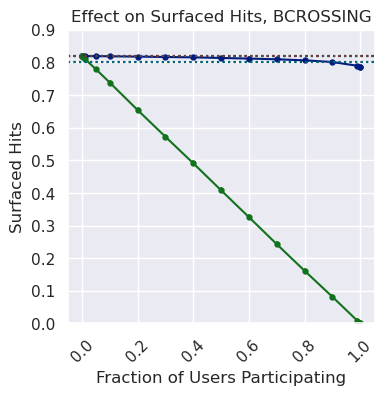

In [27]:
# Fig. 1, Upper Left
df, ds = samples_df_bc, 'bcrossing'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Surfaced Hits',
    title_template=template,
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean', 'KNNBasic_item_msd'],
    print_vals=[0.9],
    ylim=(0, 0.9),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

# Reported results: Figure 3, left

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:0.8163408942612886  |  ALL val:nan
ratio_nb: -31.83686522309411  |  ratio_all:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.8163408942612886}})


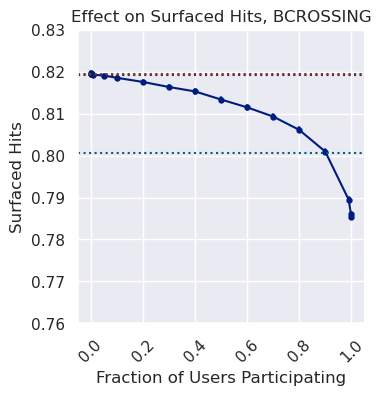

In [28]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_bc, 'bcrossing'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="Surfaced Hits",
    title_template=template,
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    ylim=(0.76, 0.83),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-14.981052631581607  |  ALL val:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -14.981052631581607}})


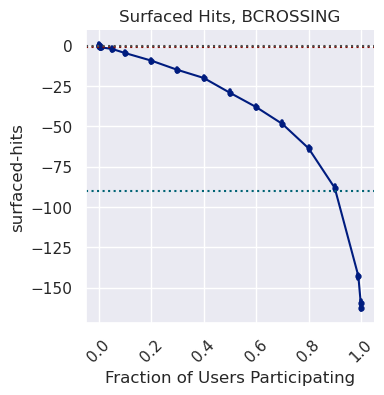

In [29]:
# ML-1M surfaced hits, normalized
df, ds = samples_df_bc, 'bcrossing'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=True,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="surfaced-hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    #ylim=(0.71, 0.78),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

In [30]:
# Set colors for below "boost coefficient" plots

pinks = {}
pinks[2] = '#f8bbd0'
pinks[3] = '#f48fb1'
pinks[4] = '#f06292'
pinks[5] = '#ec407a'
pinks[6] = '#e91e63'
pinks[7] = '#d81b60'

purples = {}
purples[2] = '#e1bee7'
purples[3] = '#ce93d8'
purples[4] = '#ba68c8'
purples[5] = '#ab47bc'
purples[6] = '#9c27b0'
purples[7] = '#8e24aa'
#https://material.io/tools/color/#!/?view.left=0&view.right=0&primary.color=E1BEE7

## Look at how total hits changes under the "boost coefficient" model

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


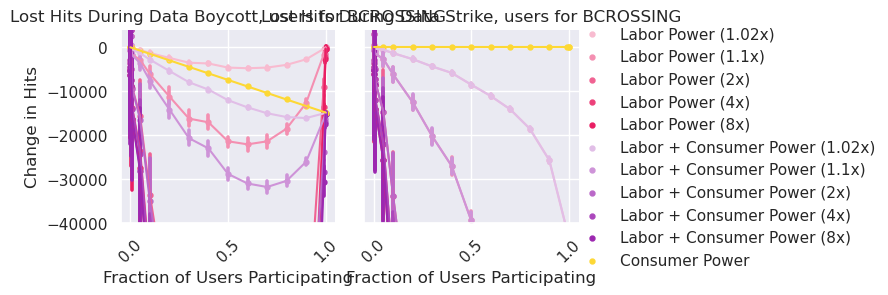

In [31]:
metric = 'totalhits'
_ = plot(
    samples_df_bc[samples_df_bc.algo_name == 'SVD'], 'bcrossing',
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=3, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], ylim=(-40000, 4000),
    print_vals=None,
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo['bcrossing'],
    id_vars=id_vars,
    ds2standards=ds2standards
)
plt.ylim=(-20000, 4000)
plt.savefig('bcrossing_totalhits.png', bbox_inches='tight', dpi=300)
plt.show()


metric = 'totalhits'
df = samples_df_20m
ds = 'ml-20m'
_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=4, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], 
    #ylim=(-120000, 500),
    print_vals=None,
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_complicatedhits.svg', bbox_inches='tight', dpi=300)
plt.show()


# Bonus results: All metrics

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


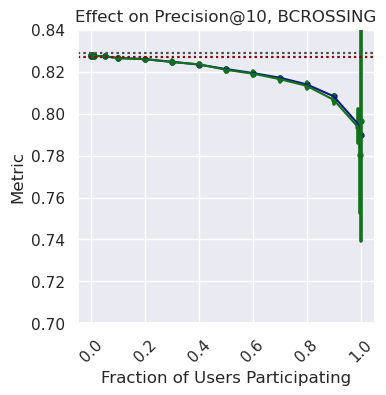

In [32]:
df, ds = samples_df_bc, 'bcrossing'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
#        'rmse',
#          'ndcg10',
#          'ndcg5',
#          'tailndcg10',
#          'ndcgfull',
         'prec10t4',
#          'rec10t4',
#          'prec5t4',
#         'rec5t4',
#          'tailprec10t4',
#         'tailrec10t4',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Metric',
    title_template=template,
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean'],
    print_vals=[],
    ylim=(0.70, 0.840),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_othermetrics.png', bbox_inches='tight', dpi=300)
plt.show()

In [33]:
import p_b_curve
import importlib
importlib.reload(p_b_curve)
plot = p_b_curve.p_b_curve

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.003147941296822596  |  ALL val:nan
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:-56.927999999999194  |  ALL val:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -28.46557397064801}})


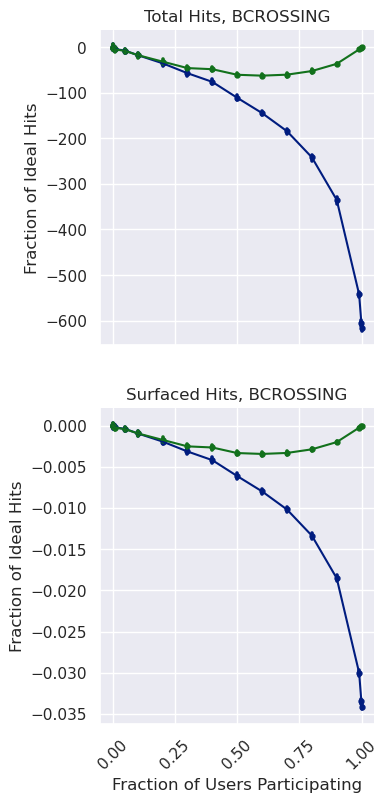

In [34]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 0
USE_INCREASE = 1
NORMALIZE = 0


df, ds = samples_df_bc, 'bcrossing'

perinc_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'surfaced-hits',
        'totalhits',
    ],
    groups=[
        'non-boycott', 'all',
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        #'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        #'MovieMean'
    ],
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_percentchange.png', bbox_inches='tight', dpi=300)
plt.show()

## Compute the 'algo_to_metric_to_group_to' for 1m in percent change

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.3841347386604353  |  ALL val:nan
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:-0.38413473866043524  |  ALL val:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.38413473866043524}})


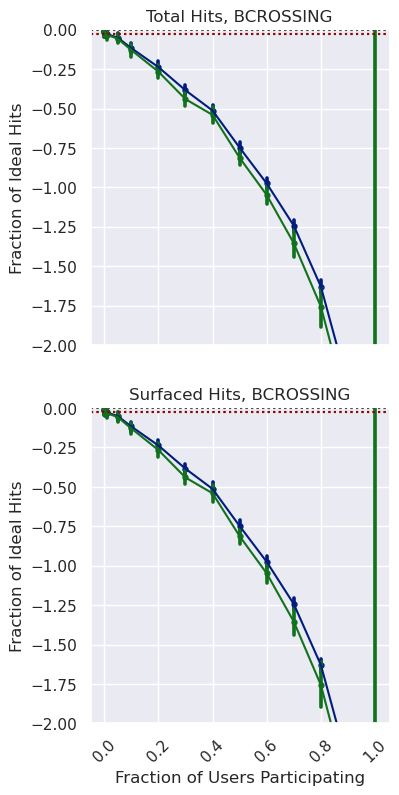

In [35]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 1
USE_INCREASE = 1
NORMALIZE = 0


df, ds = samples_df_bc, 'bcrossing'

perinc_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'surfaced-hits',
        'totalhits',
    ],
    groups=[
        'non-boycott', 'all',
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    ylim=(-2.0, 0.0),
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_percentchange.png', bbox_inches='tight', dpi=300)
plt.show()

## Compute the 'algo_to_metric_to_group_to' for 1m in normalized percent change

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.7909829067435069  |  ALL val:nan
Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-14.981052631581607  |  ALL val:nan
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:-14.981052631581607  |  ALL val:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -10.251029389968906}})


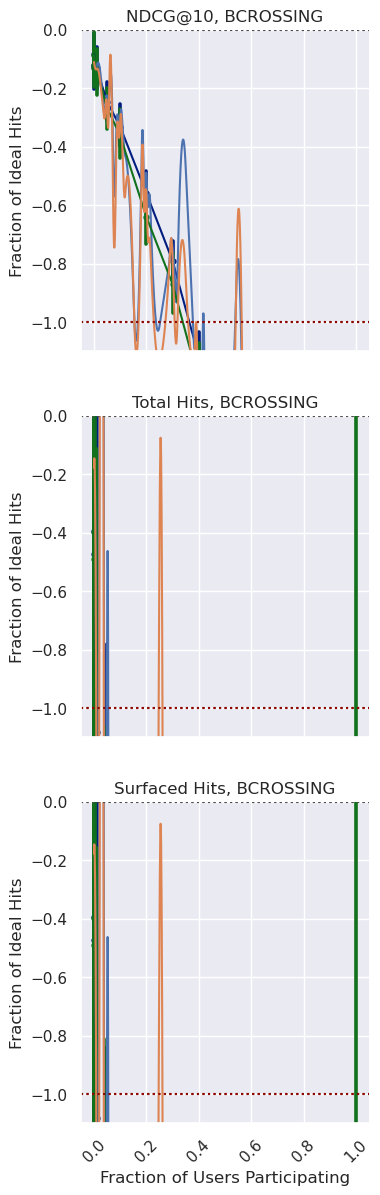

In [36]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 1
USE_INCREASE = 1
NORMALIZE = 1

df, ds = samples_df_bc, 'bcrossing'

algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=True,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'ndcg10', 
        #'normhits',
        'surfaced-hits',
        #'ndcgfull',
        'totalhits'
    ],
    groups=[
        'non-boycott', 'all',
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    ylim=(-1.1, 0),
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_norm.png', bbox_inches='tight', dpi=300)
plt.show()

In [37]:
metric = 'totalhits'
metric = 'surfaced-hits'
# comparisons = ds2standards['ml-1m']
# comparisons = {
#     key: comparisons[key].get(metric, 0) for key in comparisons.keys()
# }
comparisons = dataset_to_algo_to_metric_to_altalgo['bcrossing']['SVD'][metric]
#movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean']
for group in [
    'all', 
    #'non-boycott'
]:
    found_item, found_user = False, False
    found_itembasic = False
    for x in range(0, num_ratings['bcrossing'], int(num_ratings['bcrossing'] / 1000)):
        y = perinc_algo_to_metric_to_group_to['SVD'][metric][group]['interp_ratings'](x)
        #print(x,y)
        #print(comparisons['KNNBasic_item_msd'])

#         if not found_item:
#             if y <= comparisons['KNNBaseline_item_msd']:
#                 print(group + ' found item:')
#                 print(x / num_ratings['ml-1m'])
#                 found_item = True
#         if not found_user:
#             if y <= comparisons['KNNBasic_user_msd']:
#                 print(group + ' found user')
#                 print(x / num_ratings['ml-1m'])
#                 found_user = True
        if not found_itembasic:
            if y <= comparisons['KNNBasic_item_msd']:
                print(group + ' found knnbasicitem')
                print(x / num_ratings['bcrossing'])
                found_itembasic = True

all found knnbasicitem
0.9084366089054617


In [38]:
xvals = np.array(range(0, num_ratings['bcrossing'], int(num_ratings['bcrossing'] / 1000)))
arr = abs(perinc_algo_to_metric_to_group_to['SVD']['surfaced-hits']['all']['interp_ratings'](xvals) - comparisons['KNNBasic_item_msd'])
x = np.argmin(arr)
xvals[x]/1e6*100


13.253

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


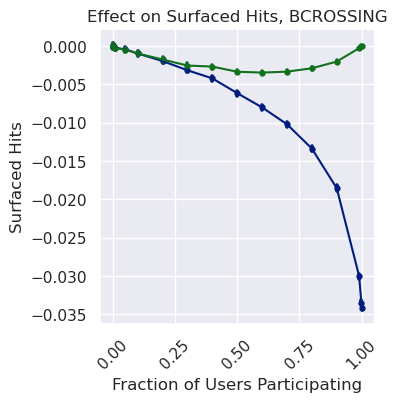

In [39]:
df, ds = samples_df_bc, 'bcrossing'

inc_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Surfaced Hits',
    title_template=template,
    height=4, aspect=1,
    line_names = [
        #'SVD', 'MovieMean', 'GlobalMean'
    ],
    print_vals=[],
    #ylim=(0, 0.8),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

# Reported Results: Effects relative to non-personalized results
## First look at the relative change in surfaced hit for non-participants

In [40]:
# effects on non-participants, normalized 
d1= {}
group = 'non-boycott'
print(group)
d1['30percent_boycott_bcrossing'] = round(algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['bcrossing']) * 100, 1)

#d1['30percent_boycott_ml-1m_ndcg10'] = round(algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 1)

pprint(d1)



non-boycott
{'30percent_boycott_bcrossing': -1580.4}


In [41]:
#round(algo_to_metric_to_group_to['SVD']['surfaced-hits']['non-boycott']['interp_ratings'](299826.82) * 100, 3)

In [42]:
d2 = {}
group = 'all'
print(group)
d2['30percent_strike_bcrossing'] = round(algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['bcrossing']) * 100, 1)
d2['37.5percent_strike_bcrossing'] = round(algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.375 * num_ratings['bcrossing']) * 100, 1)

pprint(d2)

all
{'30percent_strike_bcrossing': -1383.0, '37.5percent_strike_bcrossing': -1512.4}


## Let's look at the change in surfaced hits for the perspective of non-participants (marked "non-boycott")

In [43]:
d3 = {}
group = 'non-boycott'
d3['30_bcrossing'] = round(inc_algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['bcrossing']) * 100, 4)

pprint(d3)

{'30_bcrossing': -0.232}


# Homogenous (i.e. Targeted/Focus/shared-characteristic) Boycotts

In [44]:
def Partial_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0) 
        #& (df.algo_name == 'SVD')
    )]

In [45]:
# def Partial_ratings(df):
#     return df[(
#         (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
#     )]

In [46]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [47]:

#metrics += ['hits-prec5t4', 'labor-hits-prec5t4', 'consumer-hits-prec5t4']

metrics = [
    #'surfaced-hits', 
    'totalhits'
]

# warning: you probably do not want to change these (unless you're sure)
NORMALIZE = 0
USE_PERCENTS = 1
USE_INCREASE = 1

copy_org_df = org_df.copy()
if NORMALIZE:
    for metric in metrics:
        for algo_name in algo_names:
            movie_val = abs(dataset_to_algo_to_metric_to_altalgo['bcrossing']['SVD'][metric]['MovieMean'])
            for group in ['non-boycott', 'like-boycott', 'not-like-boycott']:
                col = 'percent_increase_{}_{}'.format(metric, group)

                copy_org_df.loc[
                    copy_org_df.algo_name == algo_name, col
                ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
                
for metric in metrics:
    expec = []
    col = '{}_expected'.format(metric)
    if USE_INCREASE:
        col = 'increase_' + col
    if USE_PERCENTS:
        col = 'percent_' + col
    for i, row in copy_org_df.iterrows():
        x = row.num_ratings_missing
        expec.append(float(perinc_algo_to_metric_to_group_to[row.algo_name][metric]['non-boycott']['interp_ratings'](x)))
    kwargs = {col: expec}
    copy_org_df = copy_org_df.assign(**kwargs)

## LB = like-boycott
### So lbless is the number cases where the like boycott performance change was less than expected

In [48]:
from p_b_curve import select_cols, fill_in_longform
ylabel = 'ylabel'

def plot2(
        df, metrics, groups,
        increase=False, percents=False, kind='bar', height=4, flip=False, filename='tmp.svg', save=False,
        palette=None, aspect=1
    ):
    """
    Plots the results of homogenous boycotts
    e.g. 50% of Comedy fans boycott together
    """
    print('len of df (number of experiments included)', len(df.index))
    for name in list(set(df.name)):
#        tmp = df[df.name == name].num_ratings_missing.mean()
        tmp = df[df.name == name].num_users_boycotting.mean()
        print('Num users boycotting: {}. As a percent: {}'.format(tmp, tmp*100))
#         print('name', name)
#         print('mean number of ratings missing', tmp)pl
#         print(algo_to_metric_to_group_to['SVD']['ndcg10']['non-boycott']['interp_ratings'](tmp))
    increase_cols = select_cols(list(df.columns.values), metrics, groups, increase=increase, percents=percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    if flip:
        x = "name"
        y = "value"
    else:
        x = "value"
        y = "name"
    if '?' in filename:
        legend = False
    else:
        legend = True
    grid = sns.catplot(
        x=x, y=y, hue="group", data=longform,
        height=height, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        legend=legend,
        legend_out=True,
        palette=palette,
        aspect=aspect
    )
    a = grid.axes
    
    name_to_ratios = defaultdict(list)
    diffs = defaultdict(dict)
    ratios = defaultdict(dict)
    vals = defaultdict(dict)
    name_to_counts = defaultdict(lambda: defaultdict(int))
    
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]        
        
        if NORMALIZE:
            val = -1
        else:
            val = abs(dataset_to_algo_to_metric_to_altalgo['bcrossing']['SVD'][metric]['MovieMean'])
        
        if flip:
            grid.axes[i_row, i_col].axhline(0, color='0.7', linestyle='-')
        else:
            grid.axes[i_row, i_col].axvline(0, color='0.7', linestyle='-')
            grid.axes[i_row, i_col].axvline(val, color='0.7', linestyle='-')
        
        cols = {}
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                
                if 'expected' in col:
                    cols['expec'] = col
                if 'not-like' in col:
                    cols['not-like'] = col
                elif 'non-boycott' in col:
                    cols['nb'] = col
                elif 'like-boycott' in col:
                    cols['lb'] = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                arrs = {}
                print(cols)
                for key in cols:
                    arrs[key] = np.array(masked[masked.increase_type == cols[key]].value)
                
                means = {key: np.mean(arrs[key]) for key in arrs}
                print(means)
                
                ratio = means['nb'] / means['expec']
                diff = means['nb'] - means['expec']
                
                lb_diff = means['lb'] / np.mean(np.array(masked.num_users_boycotting))#- means['not-like']
                lb_ratio = means['lb'] / means['not-like']

                pval = stats.ttest_ind(arrs['expec'],arrs['nb'], equal_var=False).pvalue                
                name_to_counts[name]['total'] += 1
                
                print('{} {} {}, {}, {}'.format(metric, algo_name, name, cols['expec'], cols['nb']))
                print('Ratio: {}, pval: {}'.format(ratio, pval))
                print('LB to NB ratio: {}'.format(lb_ratio))
                print('lb_diff, mean_lb - mean_nl', lb_diff)
                print('pos = lb has more hits')
                name_to_ratios[name].append(ratio)
                diffs['nb'][name] = diff
                diffs['lb'][name] = lb_diff
                
                ratios['nb'][name] = ratio
                ratios['lb'][name] = lb_ratio
                
                vals['nb'][name] = means['nb']
                vals['lb'][name] = means['lb']
                vals['not-like'][name] = means['not-like']
                
                if pval < 0.5:
                    name_to_counts[name]['total_sig'] += 1

                if diff < 0:
                    name_to_counts[name]['total_less'] += 1
                else:
                    name_to_counts[name]['total_more'] += 1
                #print('lb info', lb_diff, lb_mean, nb_mean)
                if lb_diff < 0:
                    name_to_counts[name]['total_lbless'] += 1
            except Exception as err:
                print(err)
                print(algo_name, metric)
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    total_lbless = 0
    
    for name, counts in name_to_counts.items():
        total += counts['total']
        total_sig += counts['total_sig']
        total_less += counts['total_less']
        total_more += counts['total_more']
        total_lbless += counts['total_lbless']

    print('Totals:')
    print('{} lbless, {} sig, {} less, and {} more out of {} total'.format(
            total_lbless, total_sig, total_less,
            total_more, total)
        )
    if save:
        new_labels = ['Similar Users', 'Not Participating\n Users', 'Expected']
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        if 'h2' in filename:
            grid.set_ylabels("")
        else:
            grid.set_ylabels(ylabel)
        grid.set_xlabels("")
        grid.set_titles("")
        plt.savefig(filename, size=(3, 3), bbox_inches='tight', dpi=300)
    return grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals)


In [49]:
palette={'all': 'b', 'non-boycott': 'g', 'expected': 'y', 'like-boycott': 'c', 'not-like-boycott': 'r'}

def plot_all_three_scenarios(df, height=6):

    total, total_sig, total_less, total_more, total_lbless = 0, 0, 0, 0, 0
    
    
    Partial_users_df = Partial_users(df)
    if not Partial_users_df.empty:
        grid, (total2, total_sig2, total_less2, total_more2, total_lbless2), (diffs, ratios, vals) = plot2(
            Partial_users_df,
            metrics=metrics,
            increase=USE_INCREASE, percents=USE_PERCENTS,
            flip=True,
            groups=[
                'non-boycott', 'like-boycott', 
                'expected', 
                'not-like-boycott',
            ],
            height=height,
            kind='bar',
            palette=palette
        )
        grid.fig.suptitle('Partial Users')
        total += total2
        total_sig += total_sig2
        total_less += total_less2
        total_more += total_more2
        total_lbless += total_lbless2
        print('total2', total2, total)
    
    return (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals)

In [50]:
copy_org_df = copy_org_df[copy_org_df.algo_name == 'SVD']

In [51]:
state_boycotts = copy_org_df[copy_org_df['type'] == 'state']
age_boycotts = copy_org_df[copy_org_df['type'] == 'age']

In [52]:
df3 = Partial_users(state_boycotts)
df3[50:60]

Unnamed: 0.1         name algo_name  indices  ratingfrac  userfrac  \
1300            50     malaysia       SVD  1-to-50         1.0       0.5   
1301            51        italy       SVD  1-to-50         1.0       0.5   
1302            52      austria       SVD  1-to-50         1.0       0.5   
1303            53  new zealand       SVD  1-to-50         1.0       0.5   
1304            54    singapore       SVD  1-to-50         1.0       0.5   
1305            55      finland       SVD  1-to-50         1.0       0.5   
1306            56      romania       SVD  1-to-50         1.0       0.5   
1307            57   philippine       SVD  1-to-50         1.0       0.5   
1308            58      ireland       SVD  1-to-50         1.0       0.5   
1309            59        japan       SVD  1-to-50         1.0       0.5   

     Unnamed: 0  avgest_all  avgest_all-like-boycott  avgest_boycott  \
1300   0050_SVD    3.875784                 3.922005        3.928317   
1301   0051_SVD    3.875747                 3.914411        3.939853   
1302   0052_SVD    3.876018                 3.900600        3.833899   
1303   0053_SVD    3.877006                 3.924444        3.890446   
1304   0054_SVD    3.875934                 3.818217        3.860408   
1305   0055_SVD    3.875360                 3.855224        3.964174   
1306   0056_SVD    3.875742                 3.985632        3.892241   
1307   0057_SVD    3.875716                 3.879828        3.875599   
1308   0058_SVD    3.876062                 3.914771        3.940310   
1309   0059_SVD    3.876141                 3.855449        3.983530   

      avgest_frac_all  avgest_frac_all-like-boycott  avgest_frac_boycott  \
1300              1.0                           1.0                  1.0   
1301              1.0                           1.0                  1.0   
1302              1.0                           1.0                  1.0   
1303              1.0                           1.0                  1.0   
1304              1.0                           1.0                  1.0   
1305              1.0                           1.0                  1.0   
1306              1.0                           1.0                  1.0   
1307              1.0                           1.0                  1.0   
1308              1.0                           1.0                  1.0   
1309              1.0                           1.0                  1.0   

      avgest_frac_like-boycott  avgest_frac_non-boycott  avgest_like-boycott  \
1300                       1.0                      1.0             3.914509   
1301                       1.0                      1.0             3.885231   
1302                       1.0                      1.0             3.953864   
1303                       1.0                      1.0             3.960228   
1304                       1.0                      1.0             3.776456   
1305                       1.0                      1.0             3.733408   
1306                       1.0                      1.0             4.110789   
1307                       1.0                      1.0             3.886295   
1308                       1.0                      1.0             3.889409   
1309                       1.0                      1.0             3.698101   

      avgest_non-boycott  avgrating_all  avgrating_all-like-boycott  \
1300            3.875635       3.834091                    3.828876   
1301            3.875647       3.834815                    3.937791   
1302            3.876076       3.835115                    3.909462   
1303            3.876982       3.836058                    3.876167   
1304            3.875947       3.836519                    3.683571   
1305            3.875272       3.833494                    3.877583   
1306            3.875730       3.836029                    4.454306   
1307            3.875718       3.835799                    3.986285   
1308            3.8

In [53]:
running_totals = {
    'total': 0,
    'total_sig': 0,
    'total_less': 0,
    'total_more': 0,
    'total_lbless': 0
}
all_diffs = {
    'lb': {},
    'nb': {}
}
all_vals = {
    'lb': {},
    'nb': {},
    'not-like': {},
}
all_ratios = {
    'lb': {},
    'nb': {}
}

In [54]:
# df1 = half_users(gender_boycotts)
# df2 = half_users(genre_boycotts)
# df3 = half_users(power_boycotts)

# grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot2(
#     pd.concat([df1[
#         #(df1.name.str.contains('female')) & 
#         (df1.algo_name == 'SVD')],
#         df2[(df2.name.str.contains('documentary')) & (df2.algo_name == 'SVD')],
#         df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
#     ]),
#     metrics=metrics,
#     increase=USE_INCREASE, percents=USE_PERCENTS,
#     groups=[
#         #'non-boycott', 
#         'like-boycott', 
#         #'expected',
#         'not-like-boycott',
#     ],
#     height=3.5,
#     kind='bar',
#     flip=True,
#     filename='h1.svg', save=False,
#     palette=palette,
#     aspect=1.5
# )

# plt.show()

# Age Boycotts

len of df (number of experiments included) 350
Num users boycotting: 0.11648905881395918. As a percent: 11.648905881395919
Num users boycotting: 0.025054909297974458. As a percent: 2.5054909297974457
Num users boycotting: 0.013015537297649067. As a percent: 1.3015537297649067
Num users boycotting: 0.08541446351582202. As a percent: 8.541446351582202
Num users boycotting: 0.031888066379240215. As a percent: 3.1888066379240216
Num users boycotting: 0.03725697551452046. As a percent: 3.725697551452046
Num users boycotting: 0.025705686162856907. As a percent: 2.5705686162856907
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.2460430183605443, 'nb': -0.19533814733337984, 'not-like': -0.18650329188002934, 'expec': -0.0782255372062376}
totalhits SVD 25-34, percent_increase_totalhits_expected, percent_increase_totalhits_non-boyco

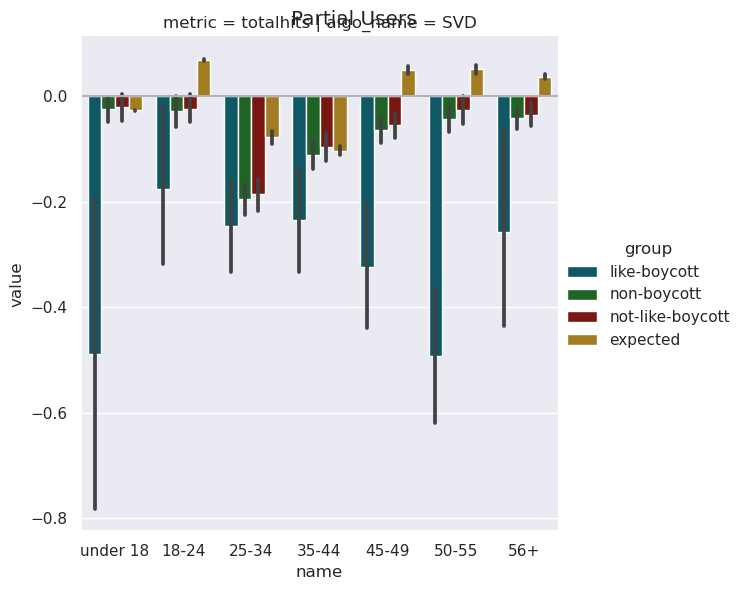

In [55]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(age_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])

plt.show()


States seemed interesting and slowed the page down a bit, so I commented out for now.
Main conclusion was that state-based boycotts seem to be pretty ineffective for basically every state.
One funny result was that it seems California users have especially low-value ratings - the performance degradation was quite off from the expected degradation (b/c CA has a lot of users).

len of df (number of experiments included) 1000
Num users boycotting: 0.008460099243471894. As a percent: 0.8460099243471895
Num users boycotting: 0.0025217603514195064. As a percent: 0.25217603514195064
Num users boycotting: 0.0018709834865370536. As a percent: 0.18709834865370537
Num users boycotting: 0.3470267631985683. As a percent: 34.70267631985683
Num users boycotting: 0.00073212397299276. As a percent: 0.073212397299276
Num users boycotting: 0.047181322703977874. As a percent: 4.7181322703977875
Num users boycotting: 0.006182380216383307. As a percent: 0.6182380216383306
Num users boycotting: 0.003741966973074107. As a percent: 0.37419669730741073
Num users boycotting: 0.0017896363784267468. As a percent: 0.1789636378426747
Num users boycotting: 0.0027658016757504274. As a percent: 0.2765801675750427
Num users boycotting: 0.01757097535182624. As a percent: 1.7570975351826241
Num users boycotting: 0.0026031074595298143. As a percent: 0.2603107459529814
Num users boycotting: 0.00

((20, 9, 12, 8, 11),
 (defaultdict(dict,
              {'nb': {'spain': -0.01535970464168816,
                'malaysia': 0.005651557765650644,
                'italy': 0.007324064305154368,
                'usa': -0.19191879044248528,
                'philippine': 0.00420942601947531,
                'canada': -0.03175152618496909,
                'france': -0.025956889670088402,
                'portugal': -0.03197513245300634,
                'austria': 0.005637010578573479,
                'netherlands': -0.011140097999945302,
                'germany': 0.00021951649142794294,
                'switzerland': -0.02665237874703204,
                'romania': -0.0035513539928347364,
                'singapore': 0.0028258862602392014,
                'ireland': -0.01585411644141292,
                'united kingdom': 0.022296263561132887,
                'australia': 0.0014232263445093304,
                'finland': -0.007456595123355138,
                'new zealand': -0.006910320626071

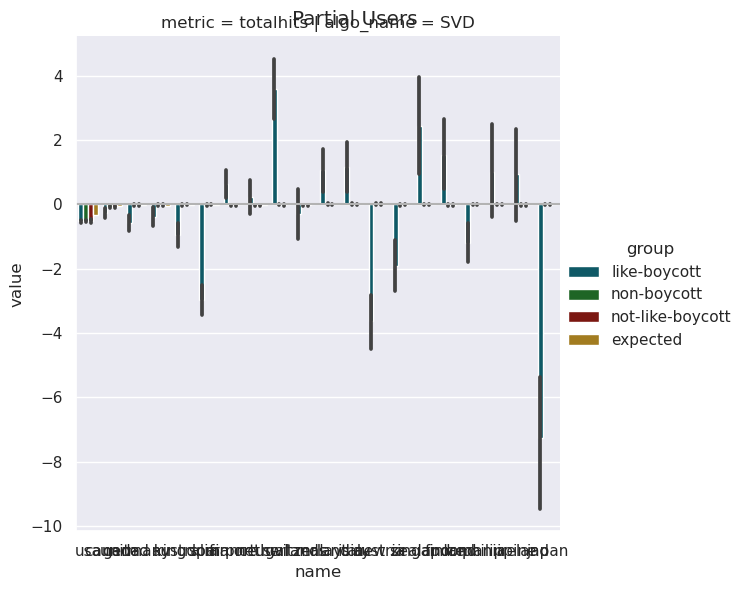

In [56]:
plot_all_three_scenarios(state_boycotts)

len of df (number of experiments included) 1000
Num users boycotting: 0.008460099243471894. As a percent: 0.8460099243471895
Num users boycotting: 0.0025217603514195064. As a percent: 0.25217603514195064
Num users boycotting: 0.0018709834865370536. As a percent: 0.18709834865370537
Num users boycotting: 0.3470267631985683. As a percent: 34.70267631985683
Num users boycotting: 0.00073212397299276. As a percent: 0.073212397299276
Num users boycotting: 0.047181322703977874. As a percent: 4.7181322703977875
Num users boycotting: 0.006182380216383307. As a percent: 0.6182380216383306
Num users boycotting: 0.003741966973074107. As a percent: 0.37419669730741073
Num users boycotting: 0.0017896363784267468. As a percent: 0.1789636378426747
Num users boycotting: 0.0027658016757504274. As a percent: 0.2765801675750427
Num users boycotting: 0.01757097535182624. As a percent: 1.7570975351826241
Num users boycotting: 0.0026031074595298143. As a percent: 0.2603107459529814
Num users boycotting: 0.00

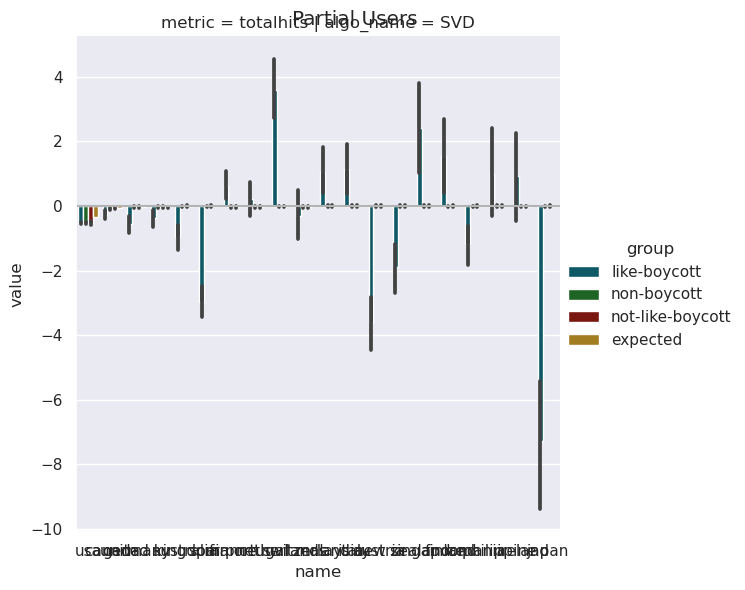

In [57]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(state_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])

plt.show()

# Reported Results: Total # of groups with overall effect less than expected

In [109]:
running_totals

{'total': 27,
 'total_sig': 14,
 'total_less': 18,
 'total_more': 9,
 'total_lbless': 18}

In [110]:
k_max = max(all_ratios['nb'], key=all_ratios['nb'].get)
print(k_max, all_ratios['nb'][k_max])

k_min = min(all_ratios['nb'], key=all_ratios['nb'].get)
print(k_min, all_ratios['nb'][k_min])

switzerland 8.249871335657097
45-49 -1.2910919373215282


In [111]:
count = 0
for k, v in all_ratios['nb'].items():
    if v > 1:
        count += 1
count

14

In [112]:
from pprint import pprint
#pprint(all_diffs)
pprint(all_ratios)
#pprint(all_vals)

{'lb': {'18-24': 7.369377215691841,
        '25-34': 1.3192422282755987,
        '35-44': 2.4460751943632,
        '45-49': 5.943155079083409,
        '50-55': 18.714872258175173,
        '56+': 7.140851898653053,
        'australia': 136.99407068298655,
        'austria': -596.0318524371551,
        'canada': 3.4500537899236132,
        'finland': -125.39587119665558,
        'france': -18.511628280641904,
        'germany': 26.095139635986335,
        'ireland': -45.452683377648874,
        'italy': 459.3258708020662,
        'japan': 954.0055123782009,
        'malaysia': -444.63802405752597,
        'netherlands': -172.4986311803542,
        'new zealand': 240.82285086703612,
        'philippine': -4588.56406847134,
        'portugal': -5.207103720456929,
        'romania': 181.79925288448666,
        'singapore': -994.6490125125512,
        'spain': 304.702666177701,
        'switzerland': 10.201332143131948,
        'under 18': 23.759434544595827,
        'united kingdom': 18.470

In [113]:
with open('all_ratios.json', 'w') as f:
    json.dump(all_ratios, f)
with open('all_diffs.json', 'w') as f:
    json.dump(all_diffs, f)
with open('all_vals.json', 'w') as f:
    json.dump(all_vals, f)

In [114]:
with open('some_distances.json', 'r') as f:
    group_to_group_to_vectype_to_distancetype_to_ = json.load(f)
    
row_dicts = []
for group, group_to_vectype_to_distancetype_to_ in group_to_group_to_vectype_to_distancetype_to_.items():
    if group == 'all':
        continue
    row_dict = {}
    row_dict['name'] = group
    for group2, vectype_to_distancetype_to_ in group_to_vectype_to_distancetype_to_.items():
        if group2 != 'all':
            continue
        for vectype, distancetype_to_ in vectype_to_distancetype_to_.items():
            for distancetype, val in distancetype_to_.items():
                row_dict['{}_{}'.format(vectype, distancetype)] = val
    row_dicts.append(row_dict)

df = pd.DataFrame(row_dicts)
df.name = [
    x.replace('excluded', '')
    .strip()
    .lower()
    for x in list(df.name)
]

In [115]:
with open('all_ratios.json', 'r') as f:
    all_ratios = json.load(f)
    
with open('all_diffs.json', 'r') as f:
    all_diffs = json.load(f)
    
with open('all_vals.json', 'r') as f:
    all_vals = json.load(f)
    
with open('group_to_num_ratings.json', 'r') as f:
    group_to_num_ratings = json.load(f)
temp_df = pd.DataFrame.from_dict(group_to_num_ratings, orient='index')
temp_df.index = [
    x.replace('excluded', '')
    .strip()
    .lower()
    for x in list(temp_df.index)
]
print(temp_df)
group_to_num_ratings = temp_df.to_dict()[0]


#print(group_to_num_ratings)    
lb_ratios = all_ratios['lb']
nb_ratios = all_ratios['nb']



row_dicts = []
for key, val in lb_ratios.items():
    row_dict = {
        'name': key,
        'like-boycott-ratio': val,
        'non-boycott-ratio': nb_ratios[key],
        'like-boycott-diff': all_diffs['lb'][key],
        'non-boycott-diff': all_diffs['lb'][key],
        'num_ratings': group_to_num_ratings[key],
        'like-boycott-val': all_vals['lb'][key],
        'not-like-val': all_vals['not-like'][key],
    }
    row_dicts.append(row_dict)
ratios_df = pd.DataFrame(row_dicts)

df = df.merge(right=ratios_df, on='name', how='inner')
print(df.head())

                     0
under 18          2538
18-24             8955
25-34            36884
35-44            26914
45-49             9316
50-55             9153
56+               7177
usa             106953
canada           13608
germany           2509
united kingdom    3383
australia         1869
spain             1374
france             977
portugal          1401
netherlands        592
switzerland        389
malaysia           958
italy              256
austria            292
new zealand        489
singapore          238
finland            156
romania            165
philippine         211
ireland             96
japan              122
all             145888
       name  implicit_euclidean  implicit_cosine  explicit_euclidean  \
0  under 18            0.229271         0.534845            0.261837   
1     18-24            0.134007         0.243307            0.139173   
2     25-34            0.081984         0.070300            0.089426   
3     35-44            0.076347         0.070

In [116]:
names = {
    'name': 'Name', 'num_ratings': '# Ratings', 
    'like-boycott-ratio': 'Similar User Effect Ratio (3)=(1)/(2)',
    'like-boycott-val':  '% change surfaced hits, similar users (1)',
    'not-like-val':  '% change surfaced hits, other users (2)',
}

table_df = df[['name', 'num_ratings', 'like-boycott-val', 'not-like-val', 'like-boycott-ratio']][
        df.name.isin([
        'under 18','18-24','25-34','35-44','45-49','50-55','56+','usa','canada','united kingdom','germany','australia','france','portugal',
    ])
    #df.num_ratings > 150000
].rename(index=str, columns=names)

print(table_df)

              Name  # Ratings  % change surfaced hits, similar users (1)  \
0         under 18       2538                                  -0.488205   
1            18-24       8955                                  -0.175563   
2            25-34      36884                                  -0.246043   
3            35-44      26914                                  -0.235844   
4            45-49       9316                                  -0.323152   
5            50-55       9153                                  -0.492311   
6              56+       7177                                  -0.258093   
7              usa     106953                                  -0.531838   
8           canada      13608                                  -0.279933   
9          germany       2509                                  -0.571198   
10  united kingdom       3383                                  -0.383146   
11       australia       1869                                  -0.966475   
13          

# Reported Results: Table 1

In [117]:
html = table_df.to_html(
    index=False,
    float_format='%.2f',
    columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio (3)=(1)/(2)',
]
)
css = """
<style>
body {column-count: 1 !important;}
table {
    width: 5.5in; height:3in;
        font-size: 9pt;
        table-layout: fixed;
}
td {
    border: 1px solid;
}
th, td, table {
    border-left: none;
    border-right: none;
    padding-left: 10px;
}

</style>
"""
table_df.to_csv('table1.csv', index=False, float_format='%.2f', columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio (3)=(1)/(2)',
])

with open('table.html', 'w') as f:
    f.write('<link rel="stylesheet" href="pubcss-acm-sigchi.css">' + css + html)

# Reported Results: Figure 4 and Correlation


len, std, mean 12 28370.87947896086 19104.916666666668


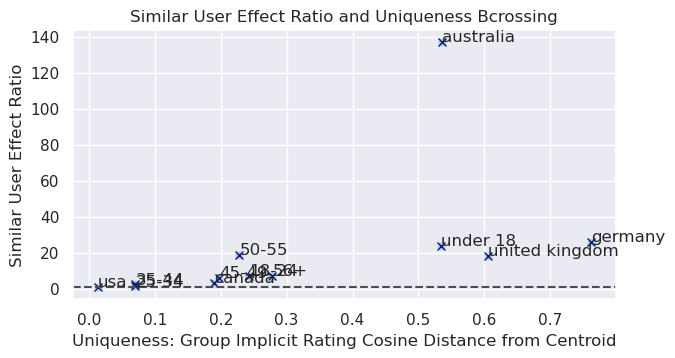

0.49136588880296783 0.10473328726720743
0.49
0.9 8.36658642909172e-05
    implicit_cosine  num_ratings  like-boycott-ratio            name
7          0.013189       106953            1.018475             usa
3          0.070187        26914            2.446075           35-44
2          0.070300        36884            1.319242           25-34
8          0.190501        13608            3.450054          canada
4          0.196850         9316            5.943155           45-49
5          0.228398         9153           18.714872           50-55
1          0.243307         8955            7.369377           18-24
6          0.278362         7177            7.140852             56+
0          0.534845         2538           23.759435        under 18
11         0.535958         1869          136.994071       australia
10         0.605187         3383           18.470965  united kingdom
9          0.761705         2509           26.095140         germany


In [118]:
# Implicit Cosine vs. LB Ratio
sns.set(style="darkgrid")
sns.set_color_codes("dark")

fig, ax = plt.subplots(1,1, figsize=(7, 3.5))
filtered = df[df.num_ratings >= 1500]
print('len, std, mean', len(filtered.num_ratings), np.std(filtered.num_ratings), np.mean(filtered.num_ratings))
#filtered = df

y = 'like-boycott-ratio'

sns.scatterplot(
    x='implicit_cosine', y=y, data=filtered,
    ax=ax, 
    #marker=".", 
    #line_kws={'alpha':.3},
    alpha=0.3
)

def label_point(x, y, val, ax, names):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if str(point['val']) in names:
            ax.text(
                point['x'], point['y']+0.2, str(point['val']), 
            )
            ax.plot(point['x'], point['y'], 'bx')

label_point(
    filtered.implicit_cosine, filtered[y], filtered.name, plt.gca(),
    names=[
       'under 18','18-24','25-34','35-44','45-49','50-55','56+','usa','canada','united kingdom','germany','australia','france','portugal',]
)  

plt.xlabel('Uniqueness: Group Implicit Rating Cosine Distance from Centroid')
plt.title('Similar User Effect Ratio and Uniqueness Bcrossing')
plt.ylabel('Similar User Effect Ratio')

ax.axhline(1, color='0.3', linestyle='--')
plt.savefig('implicitcosine_vs_lbratio.png', bbox_inches='tight', dpi=300)
plt.show()
pearson_val, pearson_p = pearsonr(filtered['implicit_cosine'], filtered[y])
print(pearson_val, pearson_p)
print(round(pearson_val, 2))
spearman_val, spearman_p = spearmanr(filtered['implicit_cosine'], filtered[y])
print(round(spearman_val, 2), spearman_p)

print(filtered[['implicit_cosine', 'num_ratings', y, 'name']].sort_values('implicit_cosine'))

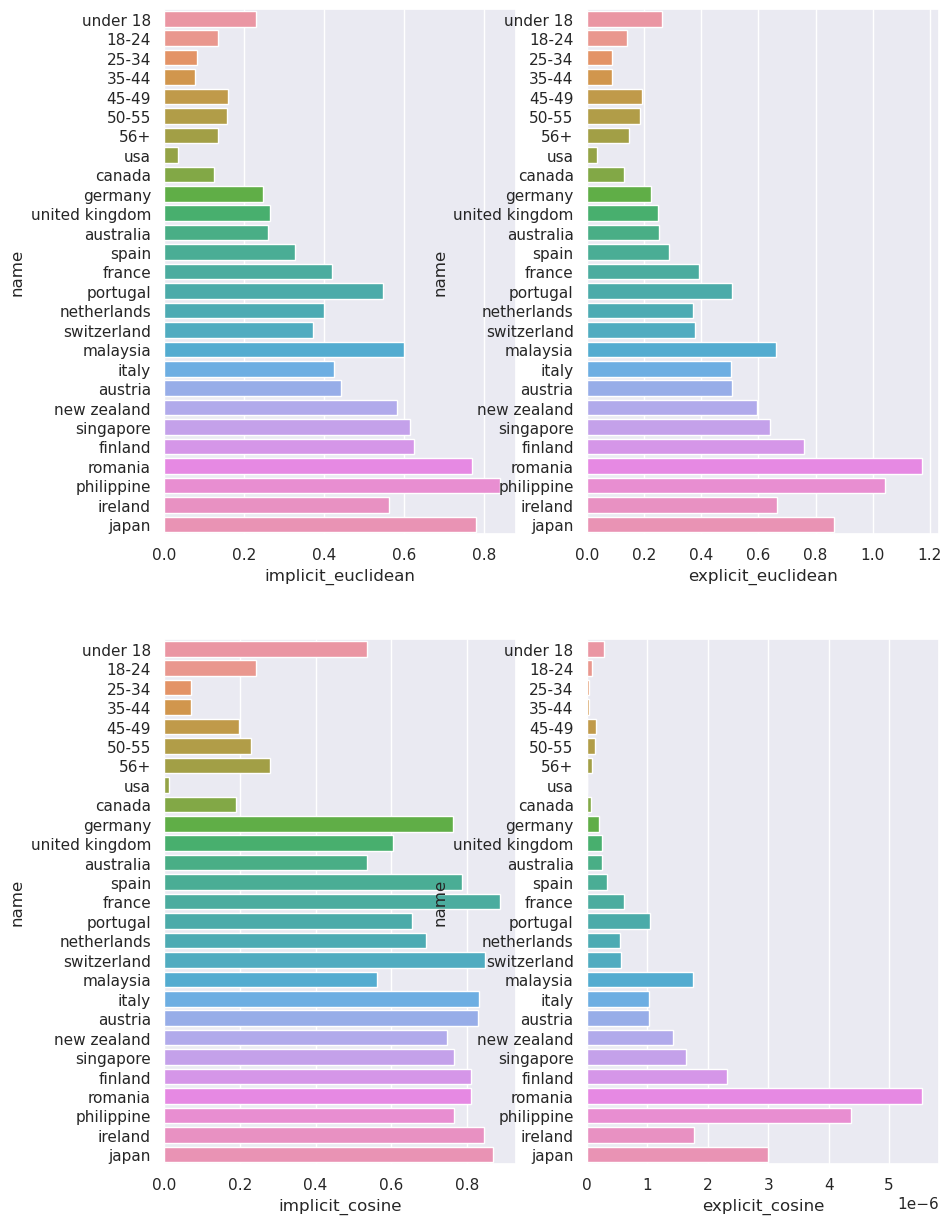

In [119]:
fig, axes = plt.subplots(2, 2, figsize=(10,15))
sns.barplot(y='name', x='implicit_euclidean', data=df, ax=axes[0,0])
sns.barplot(y='name', x='explicit_euclidean', data=df, ax=axes[0,1])
sns.barplot(y='name', x='implicit_cosine', data=df, ax=axes[1,0])
sns.barplot(y='name', x='explicit_cosine', data=df, ax=axes[1,1])
plt.show()

In [120]:
names = {
     'name': 'Name', 'num_ratings': '# Ratings', 
    'like-boycott-ratio': 'Similar User Effect Ratio (3)=(1)/(2)',
    'like-boycott-val':  '% change surfaced hits, similar users (1)',
    'not-like-val':  '% change surfaced hits, other users (2)',
}

table2_df = df[['name', 'num_ratings', 'like-boycott-val', 'not-like-val', 'like-boycott-ratio']].rename(index=str, columns=names)

table2_df.to_csv('table2.csv', index=False, float_format='%.2f', columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio (3)=(1)/(2)'
])

print(table2_df)

              Name  # Ratings  % change surfaced hits, similar users (1)  \
0         under 18       2538                                  -0.488205   
1            18-24       8955                                  -0.175563   
2            25-34      36884                                  -0.246043   
3            35-44      26914                                  -0.235844   
4            45-49       9316                                  -0.323152   
5            50-55       9153                                  -0.492311   
6              56+       7177                                  -0.258093   
7              usa     106953                                  -0.531838   
8           canada      13608                                  -0.279933   
9          germany       2509                                  -0.571198   
10  united kingdom       3383                                  -0.383146   
11       australia       1869                                  -0.966475   
12          

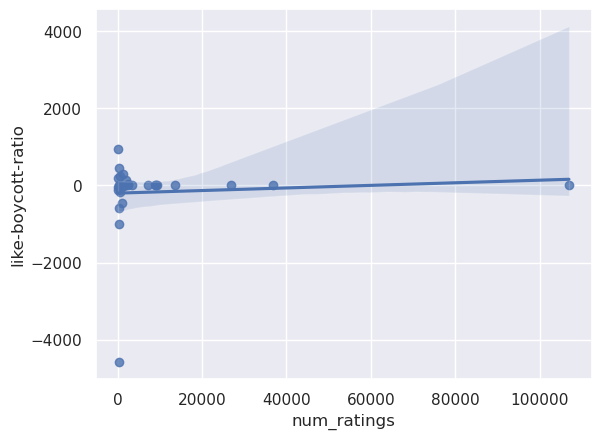

(-0.10629690194603011, 0.5977088279311256)


In [121]:
# NUM RATINGS VS LB RATIO

sns.regplot(x='num_ratings', y='like-boycott-ratio', data=df)
plt.show()
print(pearsonr(df['implicit_cosine'], df['like-boycott-ratio']))
#print(df[['implicit_cosine', 'like-boycott-ratio', 'name']].sort_values('implicit_cosine'))

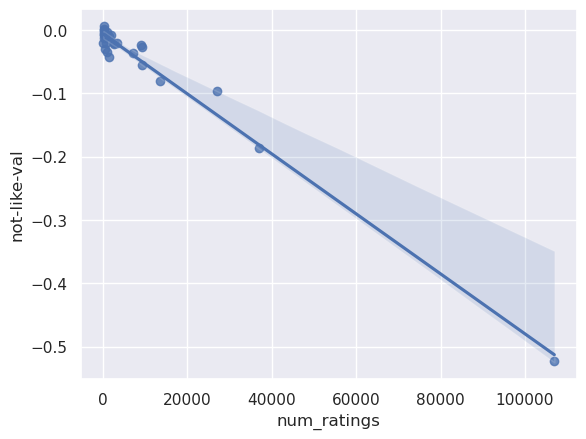

In [122]:
sns.regplot(x='num_ratings', y='not-like-val', data=df)
plt.show()

In [123]:
print(pearsonr(df['implicit_cosine'], df['like-boycott-ratio']))
print(pearsonr(df['implicit_cosine'], df['like-boycott-val']))
print(pearsonr(df['implicit_cosine'], df['not-like-val']))

(-0.10629690194603011, 0.5977088279311256)
(-0.07928279883462927, 0.694251818822372)
(0.6025200852101964, 0.0008815949132536247)


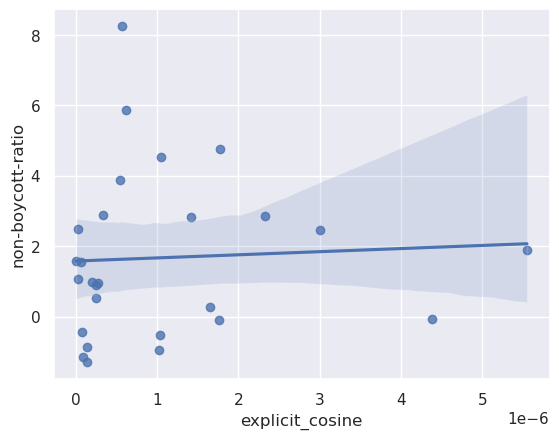

(0.052838205484163805, 0.7935169343029704)
    implicit_cosine  num_ratings  like-boycott-ratio            name
7          0.013189       106953            1.018475             usa
3          0.070187        26914            2.446075           35-44
2          0.070300        36884            1.319242           25-34
8          0.190501        13608            3.450054          canada
4          0.196850         9316            5.943155           45-49
5          0.228398         9153           18.714872           50-55
1          0.243307         8955            7.369377           18-24
6          0.278362         7177            7.140852             56+
0          0.534845         2538           23.759435        under 18
11         0.535958         1869          136.994071       australia
17         0.562745          958         -444.638024        malaysia
10         0.605187         3383           18.470965  united kingdom
14         0.654237         1401           -5.207104        

In [124]:
#large_boycotts = df[df.num_ratings > 1e5]
filtered = df
sns.regplot(x='explicit_cosine', y='non-boycott-ratio', data=filtered)
plt.show()
print(pearsonr(filtered['explicit_cosine'], filtered['non-boycott-ratio']))
print(filtered[['implicit_cosine', 'num_ratings', 'like-boycott-ratio', 'name']].sort_values('implicit_cosine'))